In [1]:
#QCNN https://www.tensorflow.org/quantum/tutorials/qcnn?hl=ja

#4qubitのqcnn
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import AdagradOptimizer
import matplotlib.pyplot as plt

In [2]:
def one_qubit_unitary(wires, params):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)
    qml.RZ(params[2], wires=wires)

def two_qubit_unitary(wires, params):
    one_qubit_unitary(wires[0], params[0:3])
    one_qubit_unitary(wires[1], params[3:6])
    qml.IsingZZ(params[6], wires=wires)
    qml.IsingYY(params[7], wires=wires)
    qml.IsingXX(params[8], wires=wires)
    one_qubit_unitary(wires[0], params[9:12])
    one_qubit_unitary(wires[1], params[12:])

def two_qubit_pool(source_wire,sink_wire ,params):
    one_qubit_unitary(sink_wire, params[0:3])
    one_qubit_unitary(source_wire, params[3:6])

    qml.CNOT(wires=[source_wire, sink_wire])

    qml.RZ(-1 *params[2], wires=sink_wire)
    qml.RY(-1 * params[1], wires=sink_wire)
    qml.RX(-1* params[0], wires=sink_wire)    

#params.shape = (15,)
def quantum_conv(wires, params):
    for first, second in zip(wires[0::2], wires[1::2]):
        two_qubit_unitary([first,second], params)
    for first, second in zip(wires[1::2], wires[2::2]+[wires[0]]):
        two_qubit_unitary([first,second], params)
        
    #回路の可読性のために挿入、動作に影響しない  
    for w in wires:
        qml.Barrier(w)
        
#params.shape = (6,)
def quantum_pool(source_wires, sink_sires, params):
    for source, sink in zip(source_wires, sink_sires):
        two_qubit_pool(source, sink,params)


In [3]:
#HWE回路のパラメータの読み込み
weights_005= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_5_6_weights.npy')
weights_035= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_35_6_weights.npy')

#データセットの読み込み
train_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/train_HWE_4q_6_005_035_no3.csv'
train_data = np.loadtxt(train_path, delimiter=',',)
X_train = train_data[:, :-1] 
y_train = train_data[:, -1]

test_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/test_HWE_4q_6_005_035_no3.csv'
test_data = np.loadtxt(test_path, delimiter=',',)
X_test = test_data[:, :-1] 
y_test = test_data[:, -1] 


In [4]:
n_wires = 4
dev = qml.device('default.qubit', wires=n_wires)
@qml.qnode(dev)
def circuit(params,x):

    #HWE回路のパラメータの選択
    if x[-1] == -1:
        gen_params = weights_005
    else:
        gen_params = weights_035
    x = x[:-1]
    x = x.reshape( ( int(x.shape[0]/2) , 2) )

    #積状態の入力
    for i in range(n_wires):
        qml.RZ(x[i][1],wires=i)
        qml.RY(x[i][0],wires=i)
    
    #HWE回路
    for layer in range(gen_params.shape[0]):
        for i in range(n_wires):
            qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i)
        for i in range(int(n_wires/2)):
            qml.CZ(wires=[2*i,2*i+1])
        for i in range(n_wires):
            qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i)
        for i in range(int((n_wires-1)/2)):
            qml.CZ(wires=[2*i+1,2*i+2])
    
    #QCNN
    quantum_conv([0,1,2,3], params[0:15])
    quantum_pool([0,1],[2,3],params[15:21])
    quantum_conv([2,3],params[21:36])
    quantum_pool([2],[3],params[36:42])

    return qml.expval(qml.PauliZ(3))


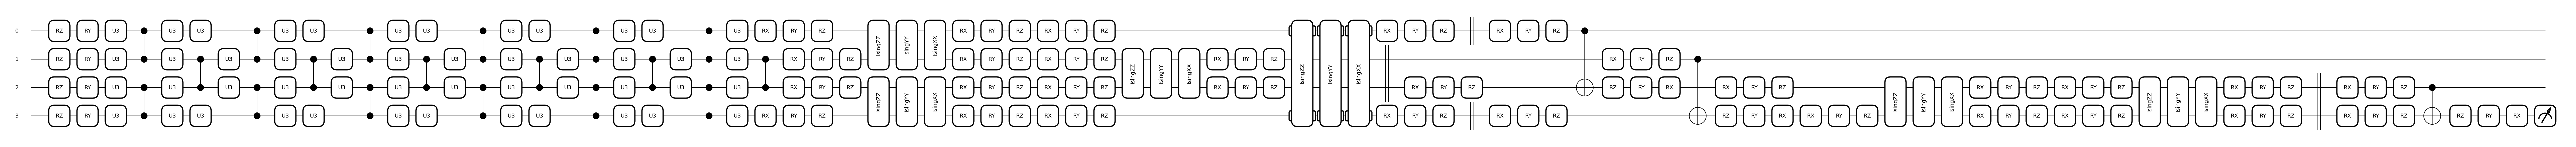

Cost after step 1: 1.062842918958216
Cost after step 2: 1.059518389003214
Cost after step 3: 1.0567923775443782
Cost after step 4: 1.0542569302048967
Cost after step 5: 1.0517022963559552
Cost after step 6: 1.049096601950946
Cost after step 7: 1.0465221821332558
Cost after step 8: 1.044122052118319
Cost after step 9: 1.042037459628103
Cost after step 10: 1.040358740254288
Cost after step 11: 1.0390977756727091
Cost after step 12: 1.038189382315028
Cost after step 13: 1.0375232637892438
Cost after step 14: 1.0369871573439762
Cost after step 15: 1.0364967285873172
Cost after step 16: 1.0360057229908697
Cost after step 17: 1.035502503840966
Cost after step 18: 1.0349988324248354
Cost after step 19: 1.0345146381455703
Cost after step 20: 1.034062865284555
Cost after step 21: 1.0336393722852182
Cost after step 22: 1.0332215598226504
Cost after step 23: 1.0327755251511392
Cost after step 24: 1.032267739983552
Cost after step 25: 1.0316757812204251
Cost after step 26: 1.030994266918556
Cost a

In [5]:
np.random.seed(42)  # ここで好きな整数を指定
params = np.random.rand(42, 1) * (2 * np.pi) 
params.requires_grad = True  # 勾配計算を有効にする

def loss(p):
    predictions = np.array([circuit(p, x) for x in X_train])
    return np.mean((predictions - y_train) ** 2)

opt = AdamOptimizer(0.01)
steps = 100

fig, ax =qml.draw_mpl(circuit)(params, X_train[0])
plt.show()
plt.close()
#print(qml.draw(circuit)(params,X_train[0]))

loss_values = []
loss_values.append(loss(params))
for i in range(steps):
    params = opt.step(loss, params)
    current_loss = loss(params)
    loss_values.append(current_loss)
    print(f"Cost after step {i + 1}: {current_loss}")
        
predictions = np.array([np.sign(circuit(params, x)) for x in X_test])
accuracy = np.mean(predictions == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

print(loss_values)

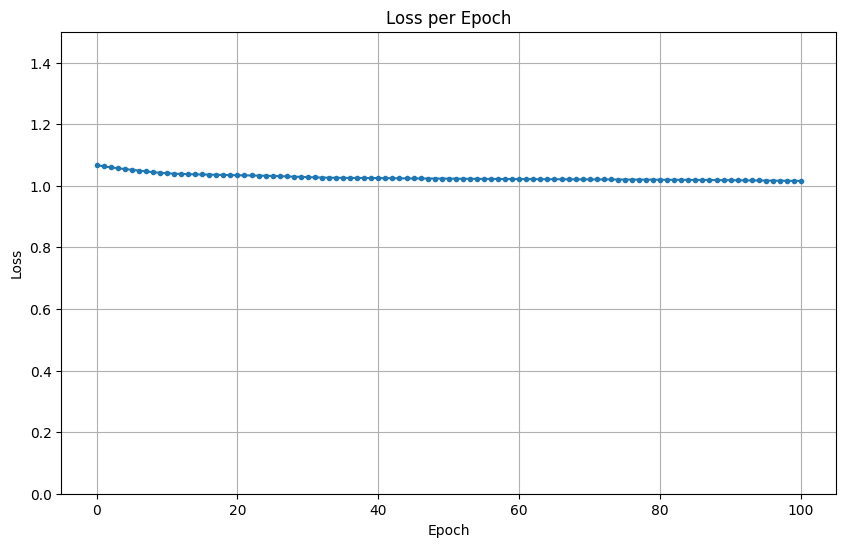

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, steps + 1), loss_values, marker='.')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.grid()
plt.show()